In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_dir = '../data'  # Assuming the base directory is '../data', adjust as necessary
null_dist = np.load(base_dir + '/mediation_signflipped_signedquantile_studymod_ctrpain_null_dist.npy', allow_pickle=True).item()
mask = nib.load(base_dir + '/full_masked_10_percent.nii')

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


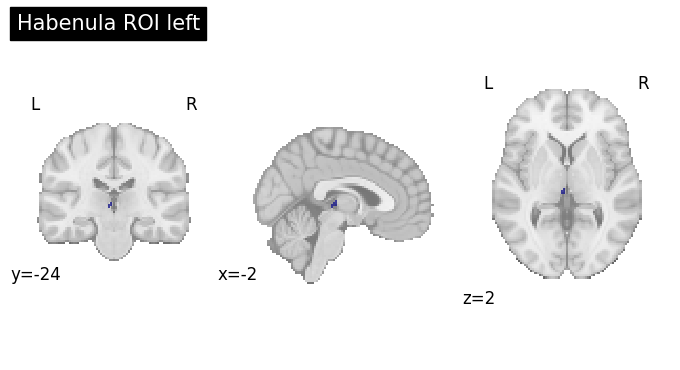

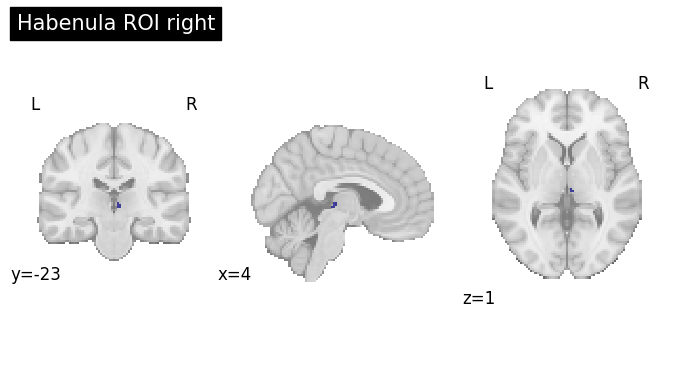

In [3]:
habenula_roi_path = '../habenula_roi/habenula_roi.nii.gz'
habenula_roi_img = nib.load(habenula_roi_path)

from nilearn.image import resample_img
# Resample the habenula ROI image to mask (2mm isotropic)
habenula_roi_img_resampled = resample_img(habenula_roi_img, target_affine=mask.affine, target_shape=mask.get_fdata().shape, interpolation='nearest')
# Update the habenula_roi_img variable to use the resampled image
habenula_resampled_data = habenula_roi_img_resampled.get_fdata()
habenula_roi_left_data = habenula_resampled_data.copy()
habenula_roi_left_data[:45, :, :] = 0
habenula_roi_right_data = habenula_resampled_data.copy()
habenula_roi_right_data[45:, :, :] = 0


from nilearn import plotting
# Plot the ROI using nilearn
plotting.plot_roi(nib.Nifti1Image(habenula_roi_left_data, affine=habenula_roi_img_resampled.affine), title="Habenula ROI left", draw_cross=False)
plotting.plot_roi(nib.Nifti1Image(habenula_roi_right_data, affine=habenula_roi_img_resampled.affine), title="Habenula ROI right", draw_cross=False)
plt.show()



In [4]:
def img2vector(image_3d, mask=None):
    """
    :param image_3d: 3d numpy.array of shape (nx, ny, nz)
    :param mask: 3d numpy array (nx, ny, nz)
    :return: numpy.array (num_samples, n_within_mask_voxels)
    """
    if mask is not None:
        vectorized = image_3d[mask>0].transpose()
    else:
        vectorized = image_3d.reshape(-1, image_3d.shape[-1]).transpose()
    return vectorized

In [5]:
habenula_roi_left_vec = img2vector(habenula_roi_left_data, mask.get_fdata())
habenula_roi_right_vec = img2vector(habenula_roi_right_data, mask.get_fdata())

In [6]:
np.sum(habenula_roi_left_vec>0), np.sum(habenula_roi_left_vec>0) 

(10, 10)

In [7]:
out_dir = base_dir + '/mediation_signflipped_signedquantile_studymod_ctrpain_results'

observed_left_habenula = {}
observed_right_habenula = {}
for contrast in null_dist.keys():
    if contrast=='Total(XY)': #no voxel data:
        continue
    beta_data = nib.load(out_dir + F'/beta_{contrast}.nii.gz').get_fdata()
    observed_left_habenula[contrast] = np.mean(beta_data[habenula_roi_left_data>0]) # mean beta within mask
    observed_right_habenula[contrast] = np.mean(beta_data[habenula_roi_right_data>0]) # mean beta within mask


In [8]:
observed_left_habenula, observed_right_habenula

({'PathA(XM)': -0.002357670811729891,
  'PathB(MY)': 0.3509382477434083,
  'Indirect(ACME)': 0.003985875845641388,
  'Direct(Total-Indirect)': 1.335454159270205,
  'INST_mean': -0.051100244498777515,
  'CONDINST_mean': -0.053457915310507406,
  'INSTandCONDINST': -0.047858298652269995},
 {'PathA(XM)': -0.016786673440624452,
  'PathB(MY)': -1.7485862696830856,
  'Indirect(ACME)': 0.030176460468245084,
  'Direct(Total-Indirect)': 1.3092635746476011,
  'INST_mean': -0.026283618581907097,
  'CONDINST_mean': -0.04307029202253155,
  'INSTandCONDINST': -0.02860947890138716})

In [9]:
import scipy.stats as stats

def tail_approx(null_data, extreme_value, tail_ratios = (0.30, 0.2, 0.1, 0.05), verbose=False):
    
    onetailed_pval = ((np.sum(null_data>=extreme_value)+1) 
                             / (null_data.shape[0] + 1))
    twotailed_pval = ((np.sum(np.abs(null_data)>=np.abs(extreme_value))+1) 
                             / (null_data.shape[0] + 1))
    
    # negate data if we need the lower tail
    if onetailed_pval > min(tail_ratios): # it's not in the right tail
        if onetailed_pval < 1 - min(tail_ratios): # it's not in the left tail
            return {'pval_original': twotailed_pval,
            'pval_pareto': twotailed_pval,
            'goodness_of_fit': np.nan,
            'tail_threshold': np.nan,
            'gpd_c': np.nan,
            'gpd_loc': np.nan,
            'gpd_scale': np.nan,
            'best_tail_ratio': np.nan
            }
        else: # it's in the lower tail, we must flip the distribution
            null_data *= -1
            extreme_value *= -1
    # else it's in the right tail, nothing to do
        
    if verbose:
        print(f"One-tailed p-value {onetailed_pval}")
    # tails can vary, get the best fit
    best_threshold = np.nan
    best_tail_ratio = None
    best_pval = np.inf
    best_gof = -1
    best_c = np.nan
    best_loc = np.nan
    best_scale = np.nan
    for tail_ratio in tail_ratios:
        # identify tail threshold
        threshold = np.quantile(null_data, 1-tail_ratio)
        # Identify the upper tail
        tail_data = null_data[null_data > threshold]
        # Fit the Generalized Pareto Distribution (GPD)
        c, loc, scale = stats.genpareto.fit(tail_data - threshold)
        # calculate the p-value
        excess_value = extreme_value - threshold
        p_value = (1 - stats.genpareto.cdf(excess_value, c, loc=loc, scale=scale)) * tail_ratio # we mltiply by the tail ratio to account for the fact that we only consider the tail
        
        # get the KS stat
        gof = stats.goodness_of_fit(stats.genpareto ,tail_data, known_params={'c': c,
                                                                        'loc': loc, 
                                                                        'scale': scale}, 
                                     random_state=42,
                                     statistic='ks').statistic
        
        if verbose:
            print(f"P-value with tail ratio {tail_ratio}: {p_value}     Goodness-of-fit: {gof}")
        
        if gof > best_gof:
            best_gof = gof
            best_threshold = threshold
            best_pval = p_value
            best_c = c
            best_loc = loc
            best_scale = scale
            best_tail_ratio = tail_ratio
            
    if best_pval == 0: # handle underflow
        best_pval = np.finfo(np.float64).tiny
            
    if verbose:
        # Plot the distribution of bootstrap correlations
        plt.hist(null_data, bins=30, edgecolor='k', alpha=0.7, density=True)
        plt.title('Tail Approximation')
        plt.xlabel('Test Statistic')
        plt.ylabel('Frequency')
            
        # Plot the fitted GPD versus the empirical tail data
        x = np.linspace(best_threshold, np.max((null_data.max(), extreme_value)), 100)
        y = stats.genpareto.pdf(x - best_threshold, best_c, loc=best_loc, scale=best_scale)
        plt.plot(x, y*best_tail_ratio, 'r-', lw=2, label='Fitted GPD')
        plt.axvline(extreme_value, color='r')
        
    return {'pval_original': twotailed_pval,
            'pval_pareto': best_pval*2,
            'goodness_of_fit': best_gof,
            'tail_threshold': best_threshold,
            'gpd_c': best_c,
            'gpd_loc': best_loc,
            'gpd_scale': best_scale,
            'best_tail_ratio': best_tail_ratio
            }


* PathA(XM)
observed: -0.002357670811729891
{'pval_original': 0.8991008991008991, 'pval_pareto': 0.8991008991008991, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* PathB(MY)
observed: 0.3509382477434083
{'pval_original': 0.8781218781218781, 'pval_pareto': 0.8781218781218781, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* Indirect(ACME)
observed: 0.003985875845641388
{'pval_original': 0.8531468531468531, 'pval_pareto': 0.8531468531468531, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* Direct(Total-Indirect)
observed: 1.335454159270205
{'pval_original': 0.5584415584415584, 'pval_pareto': 0.5584415584415584, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* INST_mean
One-tailed p-value 0.9910089910089

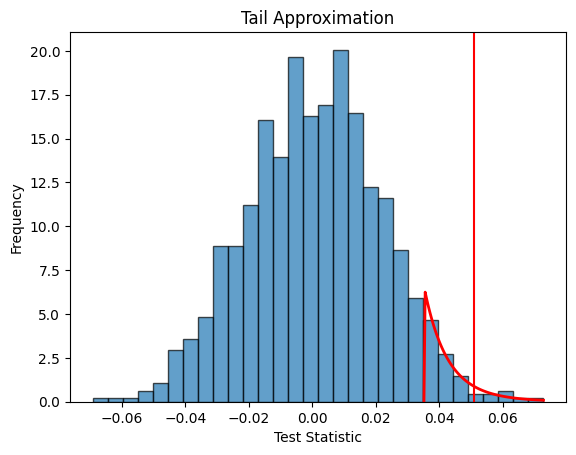

* CONDINST_mean
One-tailed p-value 0.9500499500499501
P-value with tail ratio 0.3: 0.07142752843800872     Goodness-of-fit: 0.5438196325822293
P-value with tail ratio 0.2: 0.06836588421189038     Goodness-of-fit: 0.6420963597458633
P-value with tail ratio 0.1: 0.04612928595804225     Goodness-of-fit: 0.7446289849490639
P-value with tail ratio 0.05: 0.05     Goodness-of-fit: 0.8419775851645336
observed: -0.053457915310507406
{'pval_original': 0.08291708291708291, 'pval_pareto': 0.1, 'goodness_of_fit': 0.8419775851645336, 'tail_threshold': 0.053199320706712176, 'gpd_c': 1.3651913605323753, 'gpd_loc': 0.00028029107879667633, 'gpd_scale': 0.006363148344862154, 'best_tail_ratio': 0.05}


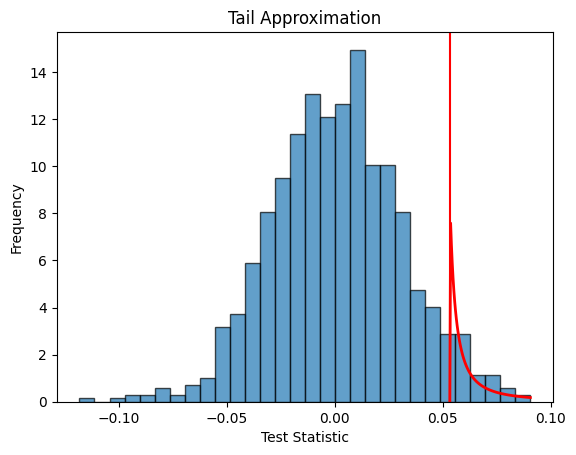

* INSTandCONDINST
One-tailed p-value 0.989010989010989
P-value with tail ratio 0.3: 0.02622299392025069     Goodness-of-fit: 0.502858319029762
P-value with tail ratio 0.2: 0.019716922016828578     Goodness-of-fit: 0.6296270264527971
P-value with tail ratio 0.1: 0.02370875804549484     Goodness-of-fit: 0.7416504623195187
P-value with tail ratio 0.05: 0.009214584920045522     Goodness-of-fit: 0.9141684912791752
observed: -0.047858298652269995
{'pval_original': 0.014985014985014986, 'pval_pareto': 0.018429169840091044, 'goodness_of_fit': 0.9141684912791752, 'tail_threshold': 0.030394269790333515, 'gpd_c': 0.4235396198357659, 'gpd_loc': 6.801007649336792e-05, 'gpd_scale': 0.0070381211450179434, 'best_tail_ratio': 0.05}


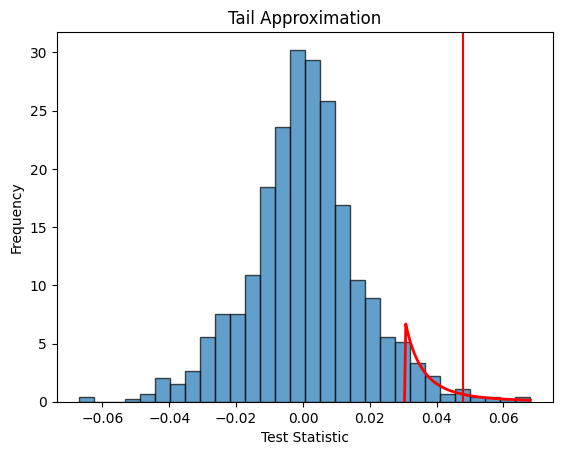

In [10]:
for contrast in null_dist.keys():
    if contrast=='Total(XY)': #no voxel data:
        continue
    print("*", contrast)
    this_null_dat_roi = null_dist[contrast][:, habenula_roi_left_vec>0].mean(axis=1) #1000 roi averages, 1 per permutation
    res = tail_approx(this_null_dat_roi, observed_left_habenula[contrast], verbose=True)
    print("observed:", observed_left_habenula[contrast])
    print(res)
    plt.show()

In [12]:
for contrast in null_dist.keys():
    if contrast=='Total(XY)': #no voxel data:
        continue
    print("*", contrast)
    this_null_dat_roi = null_dist[contrast][:, habenula_roi_right_vec>0].mean(axis=1) #1000 roi averages, 1 per permutation
    res = tail_approx(this_null_dat_roi, observed_right_habenula[contrast], verbose=True)
    print("observed:", observed_right_habenula[contrast])
    print(res)
    plt.show()

* PathA(XM)
observed: -0.016786673440624452
{'pval_original': 0.45054945054945056, 'pval_pareto': 0.45054945054945056, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* PathB(MY)
observed: -1.7485862696830856
{'pval_original': 0.5344655344655345, 'pval_pareto': 0.5344655344655345, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* Indirect(ACME)
observed: 0.030176460468245084
{'pval_original': 0.43156843156843155, 'pval_pareto': 0.43156843156843155, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* Direct(Total-Indirect)
observed: 1.3092635746476011
{'pval_original': 0.7712287712287712, 'pval_pareto': 0.7712287712287712, 'goodness_of_fit': nan, 'tail_threshold': nan, 'gpd_c': nan, 'gpd_loc': nan, 'gpd_scale': nan, 'best_tail_ratio': nan}
* INST_mean
observed: -0.026283618581907